# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [2]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [3]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [4]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [5]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [19]:
allRxnDf = pd.read_excel('EFMs.xlsx', sheet_name = 'EFM_model_input')
allRxnDf[:2]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,1,2,3,4,5,6,...,459,460,461,462,463,464,465,466,467,468
0,ATPM,H2O + ATP <=> ADP + Phosphate,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,0,0,4,0,1,0,...,6,6,5,5,5,5,5,5,5,5
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1


In [81]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}

for f in range(1,469):
    selectedRxnDf[f] = allRxnDf.loc[allRxnDf[f] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', f]]
    selectedRxnDf[f].rename(columns = {f:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf 
selectedRxnDf[369] # EFM:369 corresponds to wild-type? 

,Name,AbbreviationFormula,KeggFormula,flux
0,ATPM,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,7
1,CBP,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1
3,GLK-GTP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,1
5,PGMT,g1p <=> g6p,C00103 <=> C00092,1
6,PGI,g6p <=> f6p,C00092 <=> C00085,2
7,PFK-PPi,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,2
9,FBA,fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,2
10,TPI,dhap <=> g3p,C00111 <=> C00118,2
11,GAPDH,pi + nad + g3p <=> nadh + 13dpg,C00009 + C00003 + C00118 <=> C00004 + C00236,4
14,PGK-GTP,gdp + 13dpg <=> gtp + 3pg,C00035 + C00236 <=> C00044 + C00197,4


In [27]:
#Import metabolite bound data from excel file
Met_data = pd.read_excel('cth_thermo_model_DO_SD3.xlsx', sheet_name = 'metabolite_bounds')
Met_data

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured
0,C00008,adp,0.00050,0.000050,Cofactor,no
1,C00020,amp,0.00050,0.000050,Cofactor,no
2,C00002,atp,0.00500,0.000500,Cofactor,no
3,C00010,coa,0.00100,0.001000,Cofactor,maybe
4,C00139,fdxox,0.00100,0.001000,Cofactor,NaN
5,C00138,fdxrd,0.01000,0.000100,Cofactor,NaN
6,C00035,gdp,0.00050,0.000050,Cofactor,no
7,C00044,gtp,0.00500,0.000500,Cofactor,no
8,C00003,nad,0.01000,0.000100,Cofactor,no
9,C00004,nadh,0.00010,0.000100,Cofactor,no


In [40]:
Uf = 1 # Uncertainity factor
all_data={}
for f in range(1,469):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
           
    # calculate the min-max driving force
    mdf_data, con = pp.conc_mdf()
    #mdf_data.mdf_plot
    # store the data
    all_data[f]['mdf'] = mdf_data
    all_data[f]['con'] = con

In [60]:
all_mdf={}
for f in range(1,5):
    all_mdf[f]=all_data[f]['mdf'].mdf
all_mdf.items()

dict_items([(1, 12.200389571387301), (2, 12.200389571387301), (3, 3.1815413846184626), (4, 8.828130974326625)])

Text(0.5, 1.0, 'MDF vs ATP generated')

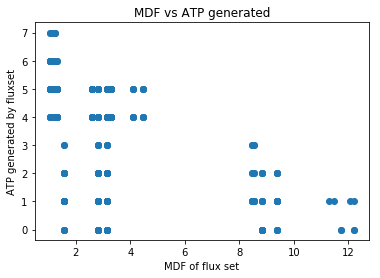

In [82]:
import matplotlib.pyplot as plt
all_mdf={}
for f in range(1,469):
    all_mdf[f]=float(all_data[f]['mdf'].mdf)
df1 = pd.DataFrame.from_dict(list(all_mdf.items()))    
all_atp={}   
for f in range(1,469):
    try:
        all_atp[f]=selectedRxnDf[f]['flux'][0] # assuming all ATP generated ate being consumed by ATPM, 1st reaction, have to check this
    except:
        all_atp[f]=0
df2 = pd.DataFrame.from_dict(list(all_atp.items()))         

plt.scatter(df1[1],df2[1])
plt.xlabel('MDF of flux set')
plt.ylabel('ATP generated by fluxset')
plt.title('MDF vs ATP generated')

1